In [25]:
%matplotlib inline
import cv2
import glob
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms
from torchvision.transforms import *

In [26]:
class GradCam:
    def __init__(self, model):
        self.model = model
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            for name, module in self.model.named_children():
                if name == 'block8':
                    feature = module(feature)
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                elif name == 'last_linear':
                    feature = feature.view(feature.size(0), -1)
                    feature = module(feature)
                else:
                    feature = module(feature)
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()
            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

In [27]:
def get_config():
    config = {
        'dataset':"./test_data",
        'weight':"./weight.pth",
        'classes':['class_1', 'class_2', 'class_3', 'class_4'] # write class names in alphabetical order
    }
    return config

In [28]:
def prewhiten(x):
    mean = x.mean()
    std = x.std()
    std_adj = std.clamp(min=1.0/(float(x.numel())**0.5))
    y = (x - mean) / std_adj
    return y

In [29]:
def run(config):    
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'
    model = InceptionResnetV1(classify=True,num_classes=4).to(device).eval()
    model.load_state_dict(torch.load(config['weight'], map_location=torch.device(device)))
    grad_cam = GradCam(model)
    transform = transforms.Compose([
        Resize((160,160)),
        np.float32,
        ToTensor(),
        prewhiten
    ])
    print("start Grad-Cam")
    for path in glob.glob("{}/*".format(config['dataset'])):
        img = Image.open(path)
        img_size = img.size
        tensor_img = transform(img).unsqueeze(0)
        plt.title("test image")
        plt.imshow(img)
        plt.show()
        feature_img = grad_cam(tensor_img).squeeze(dim=0)
        feature_img = transforms.ToPILImage()(feature_img)
        pred_idx = model(tensor_img).max(1)[1]
        print("pred: ", config["classes"][int(pred_idx)])
        plt.title("Grad-CAM feature image")
        plt.imshow(feature_img.resize(img_size))
        plt.show()
        print("--------------------")

start Grad-Cam


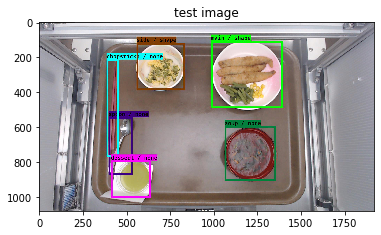

pred:  class_1


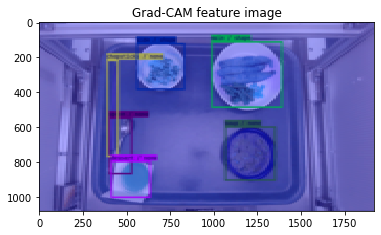

--------------------


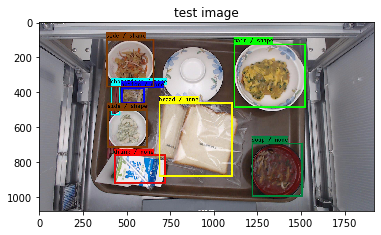

pred:  class_1


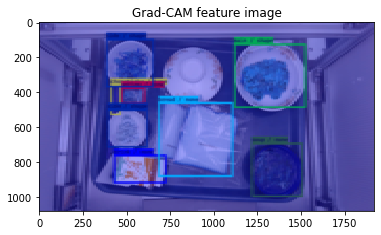

--------------------


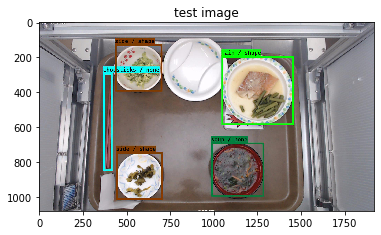

pred:  class_1


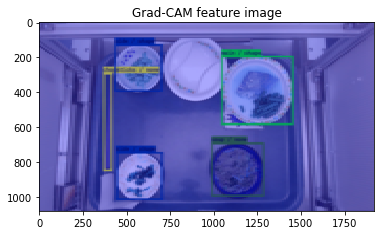

--------------------


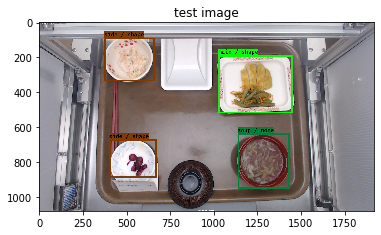

pred:  class_1


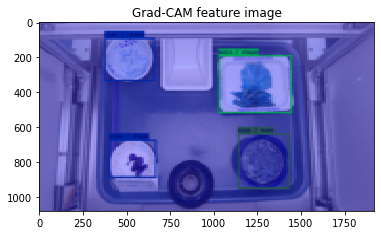

--------------------


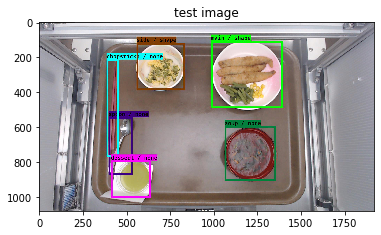

pred:  class_1


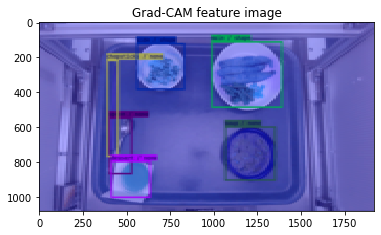

--------------------


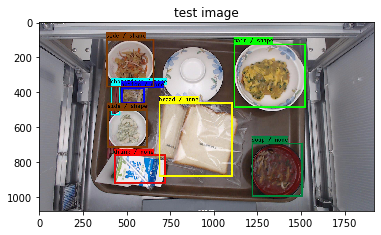

pred:  class_1


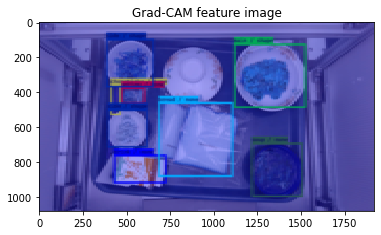

--------------------


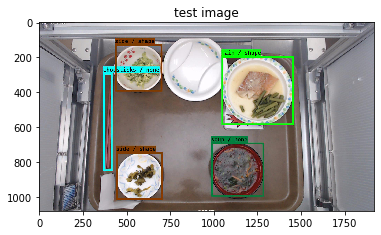

pred:  class_1


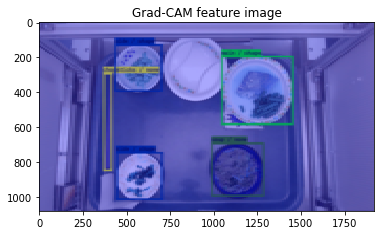

--------------------


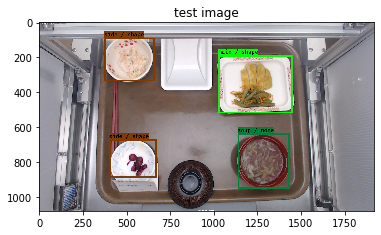

pred:  class_1


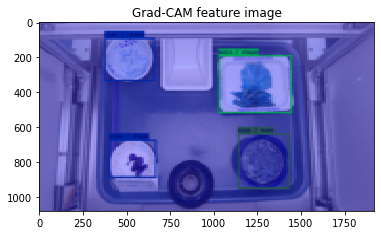

--------------------


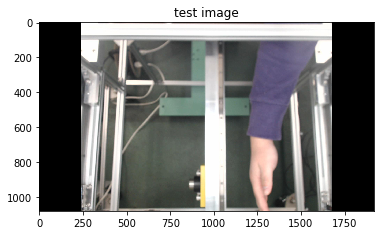

pred:  class_1


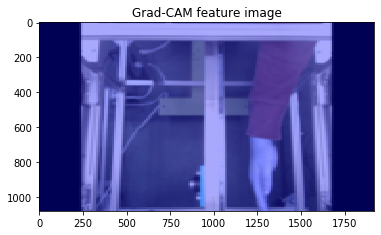

--------------------


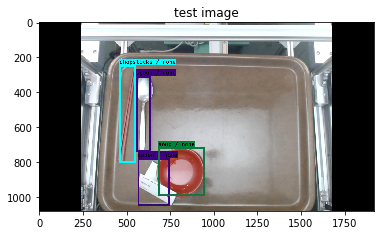

pred:  class_1


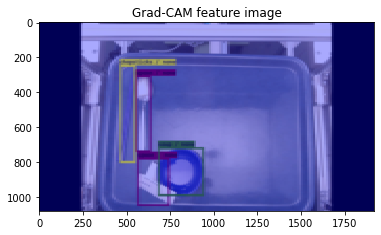

--------------------


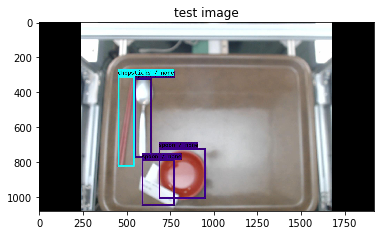

pred:  class_1


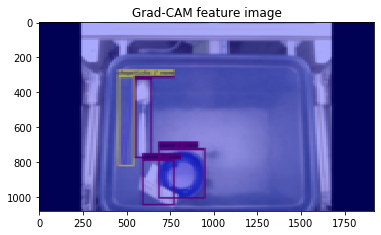

--------------------


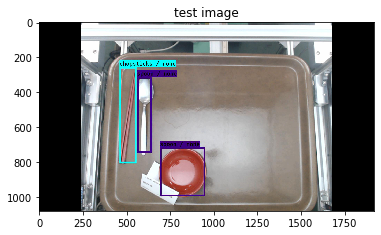

pred:  class_1


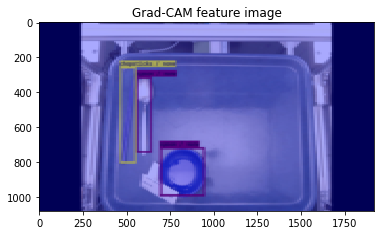

--------------------


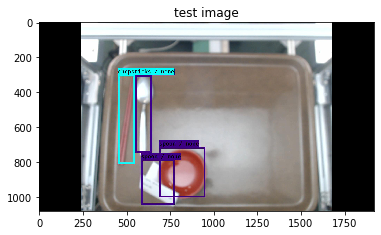

pred:  class_1


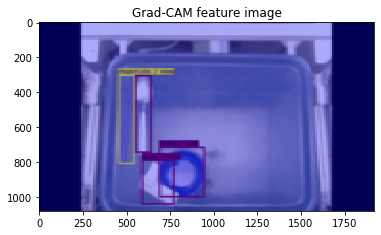

--------------------


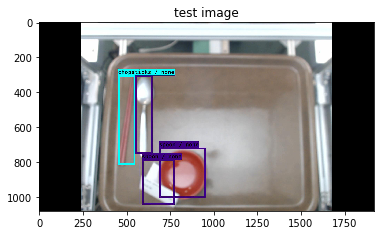

pred:  class_1


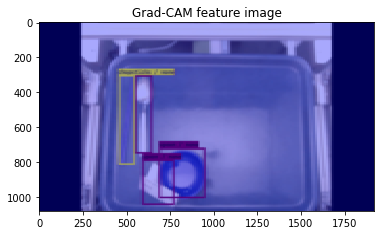

--------------------


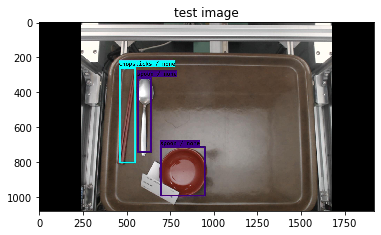

pred:  class_1


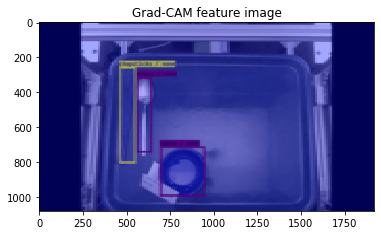

--------------------


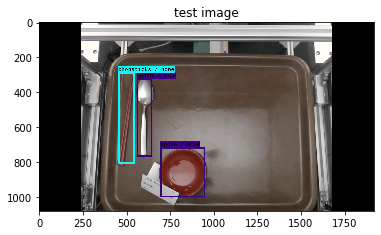

pred:  class_1


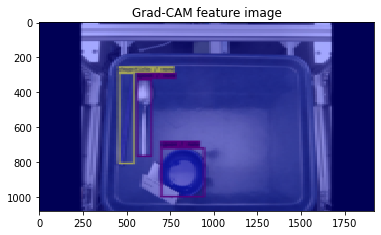

--------------------


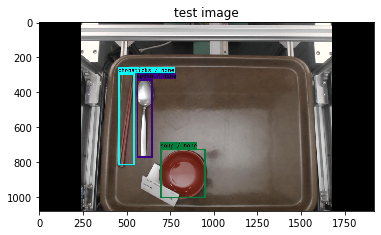

pred:  class_1


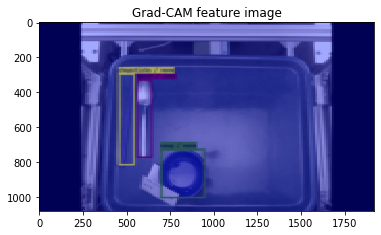

--------------------


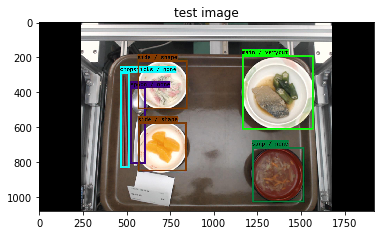

pred:  class_1


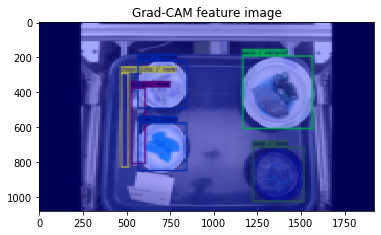

--------------------


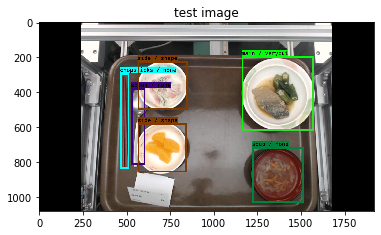

pred:  class_1


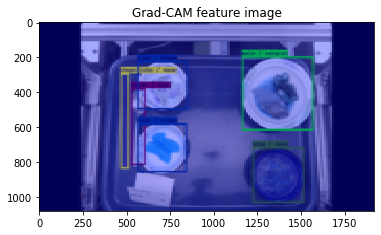

--------------------


In [30]:
config = get_config()
run(config)